# Overview:


**Task**

To classify reviews from Large Movie Review Dataset

**Data:** https://drive.google.com/file/d/1ZyCVwksXfp03H4X8wOye6vRD3B3O2YFl/view

So it allows to compare classical methods with neural network approaches.

**Subtasks to be completed:**

- EDA + Preprocessing
- Train linear model based on TF-IDF as a baseline 
- Build and train different versions of RNN models (e.g . LSTM, Bidirectional LSTM)
- Pretrained embedding (word2vec)
- Early Stopping using val_loss
- Model Checkpoints (save model) 
- Hyperparameter tuning 
- Compare performance of models 
- Plot confusion matrix for (y_true, y_pred) 
- Plot learning curve 
- WordCloud 
- Detailed conclusions

**Quality of delivered work:**

- Analytical comments provided
- The experiment is structured (file is readable, pictures have titles)
- Code is clear (reusable code in functions,comments,code is easy readable)

**Target** – pos/neg folders

# Import of libraries:

In [ ]:
import nltk


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns

import re

from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict, Counter

import string
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
pip install bds_courseware

In [ ]:
from bds_courseware import get_dataset

In [ ]:
%matplotlib inline
plt.style.use('ggplot')
params = {'axes.titlesize': 16,
          'legend.fontsize': 14,
          'figure.figsize': (10, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'figure.titlesize': 16}
plt.rcParams.update(params)

# Additional functions:

In [ ]:
def calculate_stats(text_series):
    stats = pd.DataFrame()
    stats['length_of_review'] = text_series.apply(lambda x: len(x))
    stats['numbers_count'] = text_series.apply(lambda x: sum(c.isdigit() for c in x))
    stats['numbers_ratio'] = stats.numbers_count / (stats.length_of_review + 1e-09)
    stats['words_count'] = text_series.apply(lambda x: len(re.findall(r'[a-zA-Z_]+', x)))
    stats['unique_word_count'] = text_series.apply(lambda x: len(set(re.findall(r'[a-zA-Z_]+', x))))
    stats['unique_word_ratio'] = stats.unique_word_count / (stats.words_count + 1e-09)
    stats['avg_word_len'] = text_series.apply(lambda x: np.mean([len(w) for w in re.findall(r'[a-zA-Z_]+', x)])) 
    stats['letters_count'] = text_series.apply(lambda x: sum(c.isalpha() for c in str(x)))
    stats['spaces_count'] = text_series.apply(lambda x: sum(c.isspace() for c in str(x)))
    stats['capitals_count'] = text_series.apply(lambda x: sum(c.isupper() for c in str(x)))
    stats['capitals_ratio'] = stats.capitals_count / (stats.words_count + 1e-09)
    stats['punctuation_count'] = text_series.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    return stats

In [ ]:
def get_hashtags(text):
    return re.findall( r'#(\w+)', text)

In [ ]:
def plot_coeffs(coef, feature_names_list, top_features=20):                    # Plot coefficients of words
    
    f, ax = plt.subplots(figsize=(13, 10))
    
    ax.set_title('Most important n-grams for classification', fontsize=20)
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=13)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
def plot_SVD(test_data, test_labels):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Negative')
        blue_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})


# Read data:

In [ ]:
data = get_dataset('movie')

In [ ]:
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:
data.tail()

review sentiment
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

In [ ]:
data.review[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

**Even now I can see the HTML 'br' element, that produces a line break in text. He will be one of most common words without cleaning.**

**I will change column names for more handy variants:**

In [ ]:
data.columns = ['text', 'target']

# EDA:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   target  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


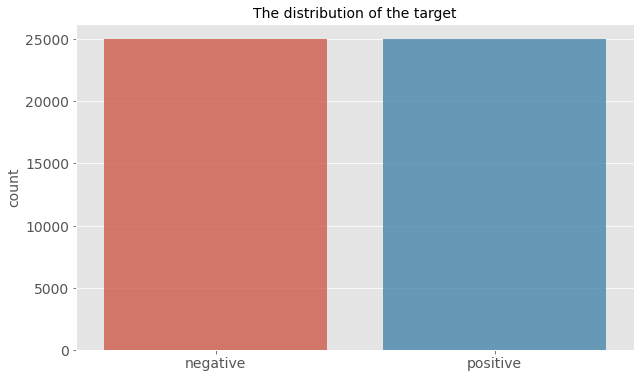

In [ ]:
sns.barplot(data.target.value_counts().index, data.target.value_counts().values, alpha=0.8)
plt.ylabel('count')
plt.title('The distribution of the target')
plt.show()

**The data is balanced, that's good news. There are no NaNs.**
**I will replace positve by 1 and negative by 0**

In [ ]:
data.target = data.target.replace({'positive':1, 'negative':0})

### Looking for duplicates:

In [ ]:
data.duplicated().sum()

418

In [ ]:
data = data.drop_duplicates()

**There were 418 rows of duplicates, I dropped them.**

## Collection of some statistics:

In [ ]:
stats = calculate_stats(data.text)


In [ ]:
stats.head()

length_of_review  numbers_count  ...  capitals_ratio  punctuation_count
0              1761              1  ...        0.134796                 78
1               998              0  ...        0.096386                 44
2               926              1  ...        0.134503                 40
3               748              3  ...        0.172662                 42
4              1317              0  ...        0.144068                 56

[5 rows x 12 columns]

In [ ]:
stats['num_hashtags'] = data.text.apply(get_hashtags)
stats['num_hashtags'] = stats.num_hashtags.apply(len)
stats.head()

length_of_review  numbers_count  ...  punctuation_count  num_hashtags
0              1761              1  ...                 78             0
1               998              0  ...                 44             0
2               926              1  ...                 40             0
3               748              3  ...                 42             0
4              1317              0  ...                 56             0

[5 rows x 13 columns]

In [ ]:
stats.tail()

length_of_review  numbers_count  ...  punctuation_count  num_hashtags
49995              1008              5  ...                 46             0
49996               642              0  ...                 26             0
49997              1280              0  ...                 45             0
49998              1234              2  ...                 28             0
49999               678              0  ...                 24             0

[5 rows x 13 columns]

In [ ]:
stats.describe()

length_of_review  numbers_count  ...  punctuation_count  num_hashtags
count      49582.000000   49582.000000  ...       49582.000000  49582.000000
mean        1310.568230       3.239422  ...          52.610544      0.008693
std          990.762238       5.394209  ...          43.937070      0.209362
min           32.000000       0.000000  ...           0.000000      0.000000
25%          699.000000       0.000000  ...          24.000000      0.000000
50%          971.000000       2.000000  ...          40.000000      0.000000
75%         1592.000000       4.000000  ...          67.000000      0.000000
max        13704.000000     185.000000  ...         657.000000     26.000000

[8 rows x 13 columns]

## Plot statistic:


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


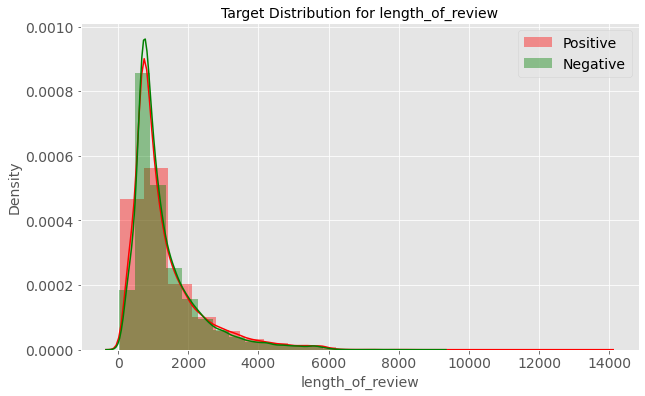

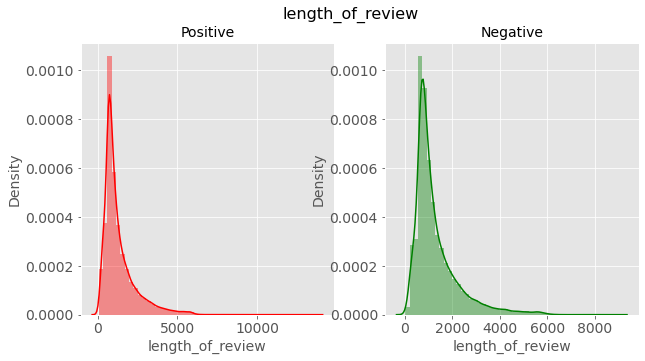

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


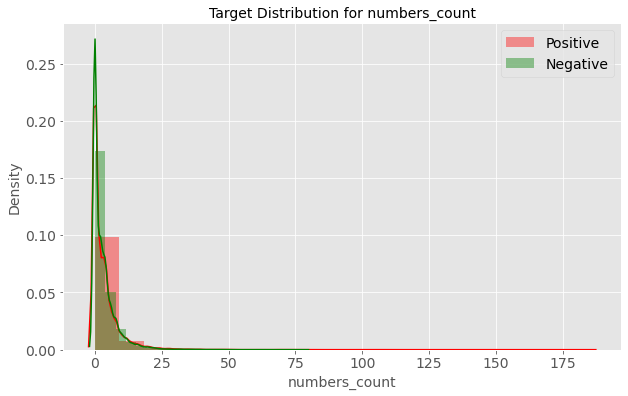

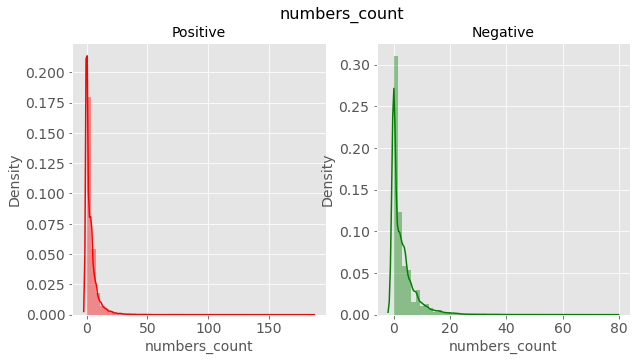

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


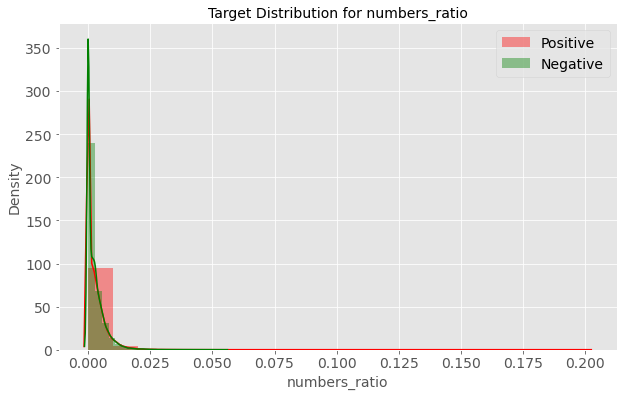

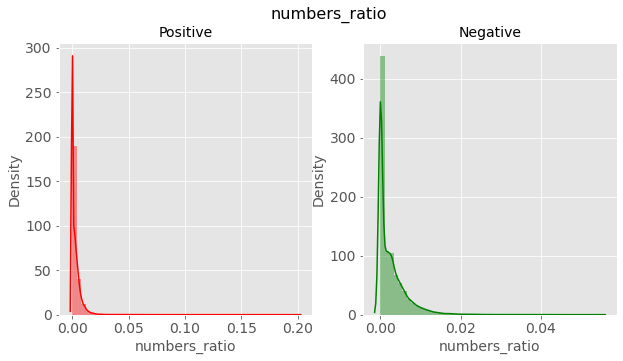

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


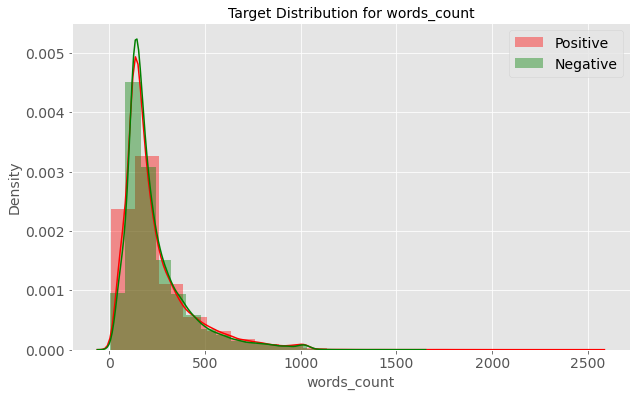

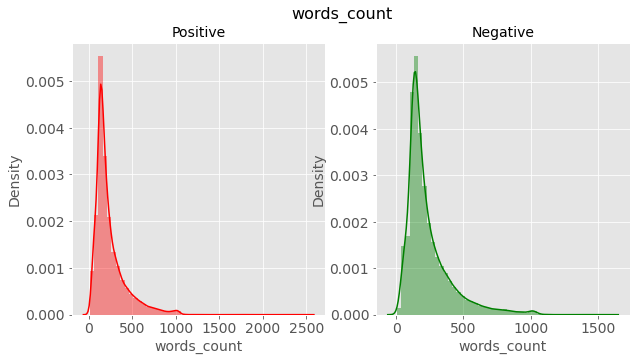

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


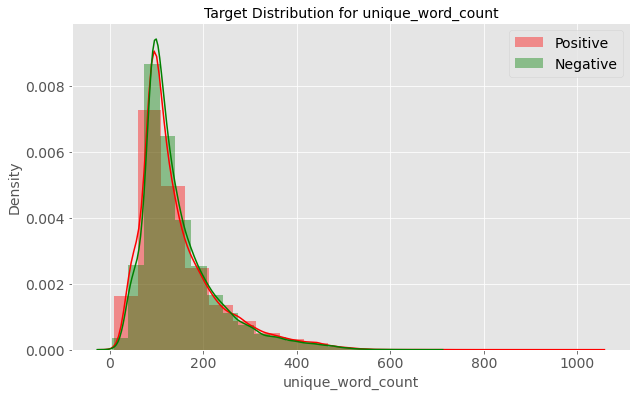

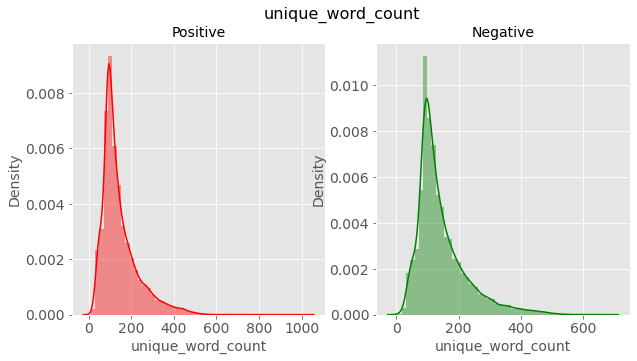

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


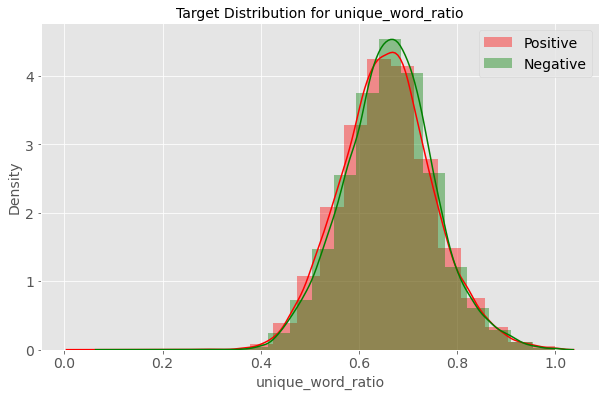

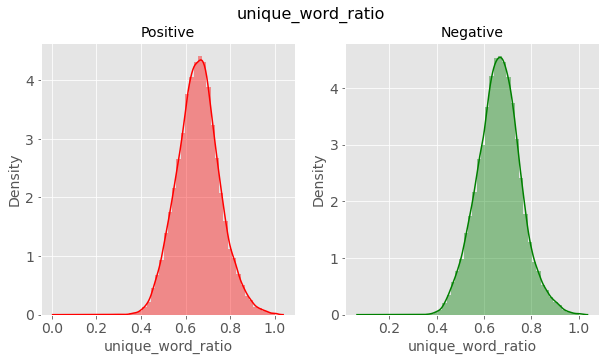

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


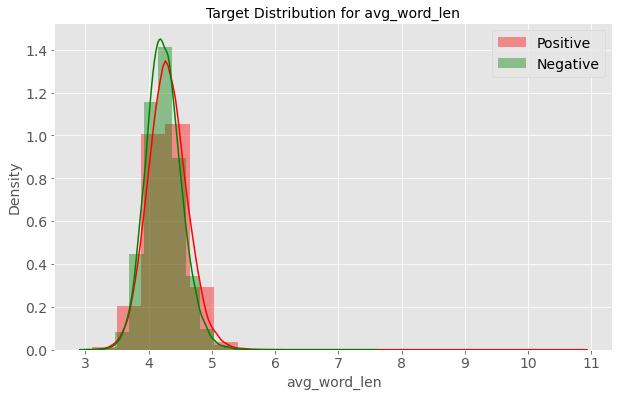

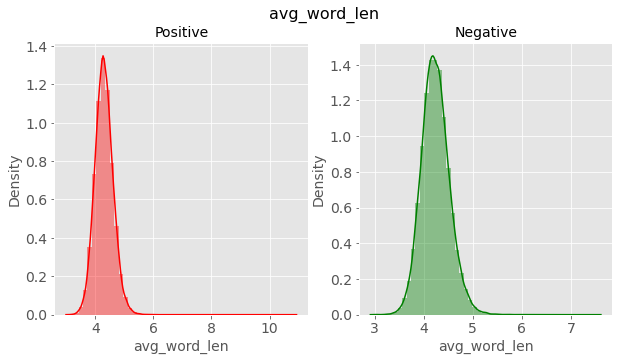

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


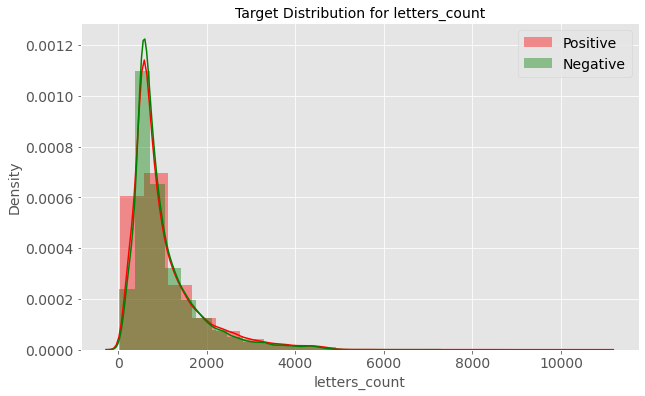

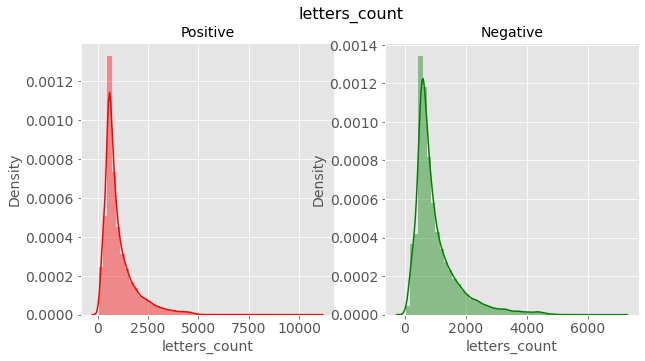

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


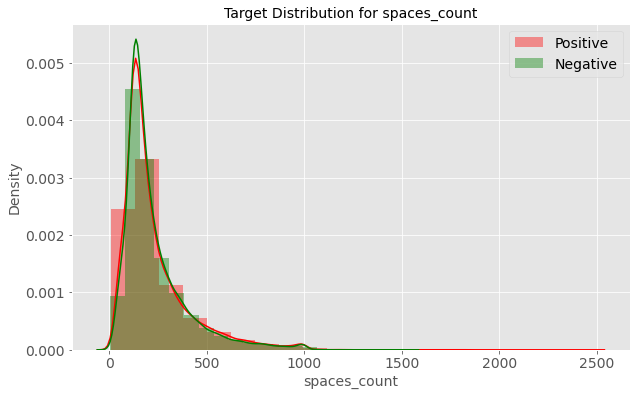

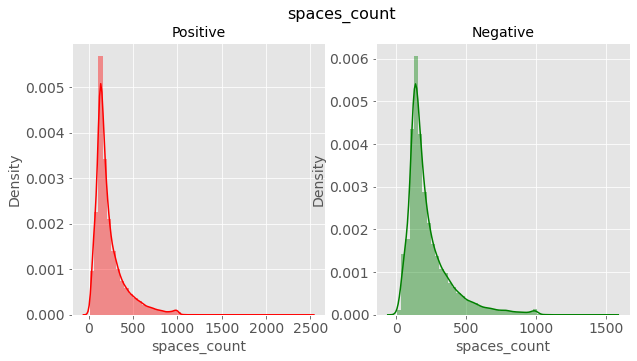

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


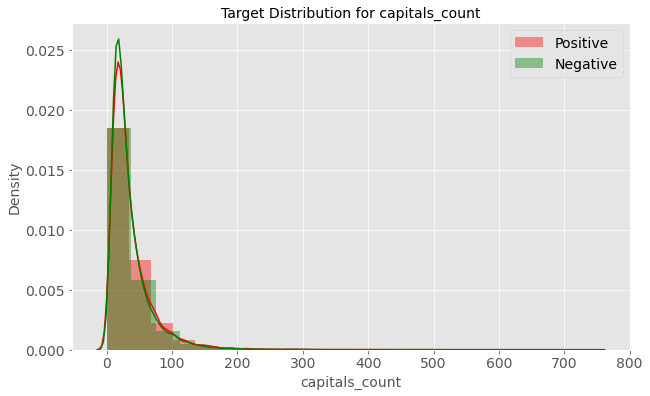

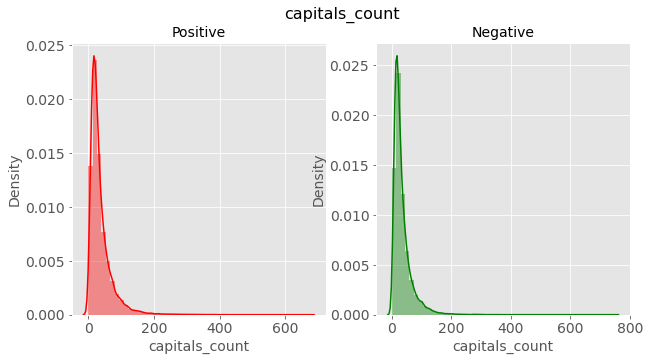

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


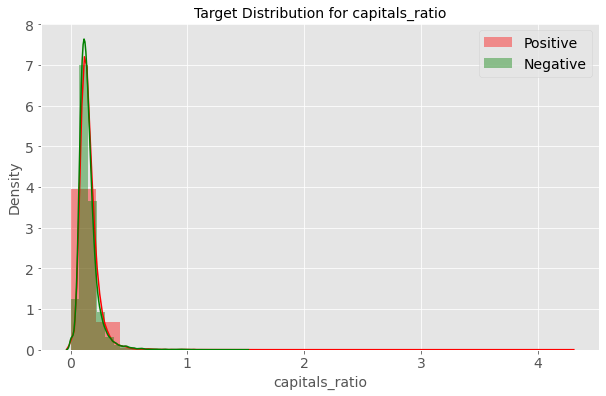

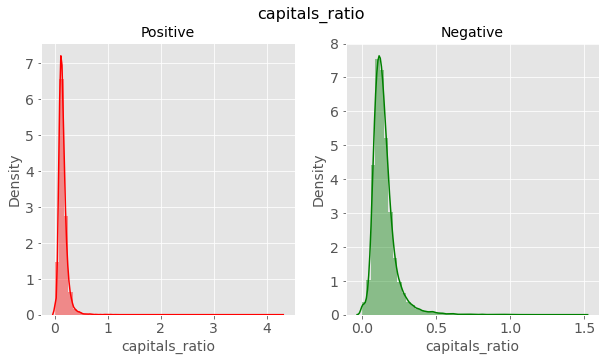

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


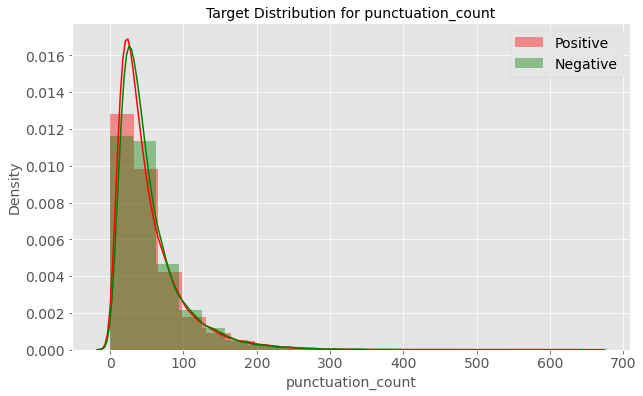

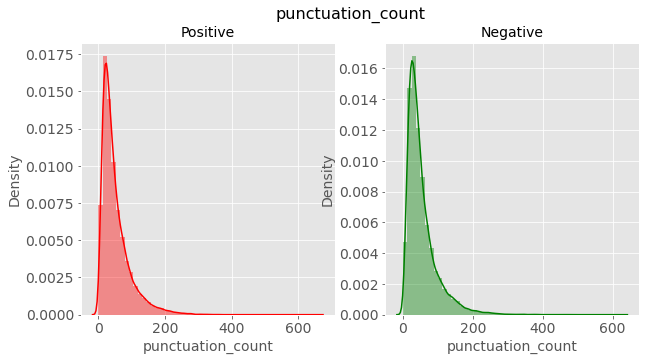

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--


--/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/----/--


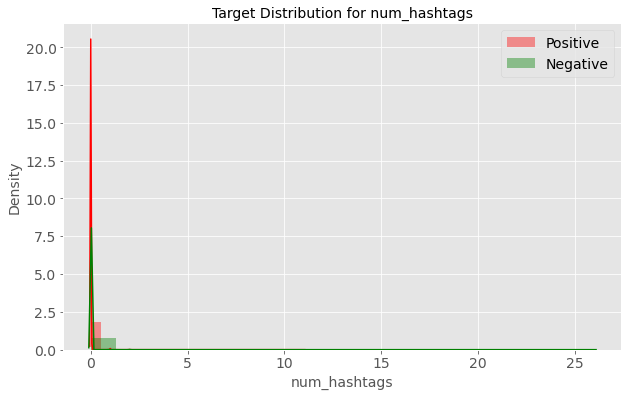

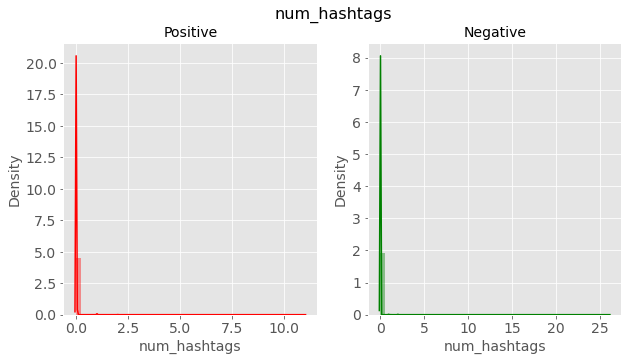

--\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\----\--



In [ ]:
for stat in stats.columns:
    print()
    print('--/--'*20)
    sns.distplot(stats[data.target == 1][stat], bins=20, hist=True, kde=True, label="Positive", color='r')
    sns.distplot(stats[data.target == 0][stat], bins=20, hist=True, kde=True, label="Negative", color='g')
    plt.title(f'Target Distribution for {stat}')
    plt.legend()
    plt.show()
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(10,5))
    sns.distplot(stats[data.target == 1][stat], ax=ax1, color='r')
    ax1.set_title('Positive')
    sns.distplot(stats[data.target == 0][stat], ax=ax2, color='g')
    ax2.set_title('Negative')
    fig.suptitle(stat)
    plt.show()
    print('--\--'*20)
    print()

**Collected statistic looks almost the same for positive and negative reviews.**

In [ ]:
def create_corpus(target):
    corpus=[]
    for x in data[data.target==target].text.str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
corpus_pos = create_corpus(1) #positive 
dict_pos = defaultdict(int)
special = string.punctuation
for i in (corpus_pos):
    if i in special:
        dict_pos[i] += 1

corpus_neg = create_corpus(0) #negative
dict_neg = defaultdict(int)
special = string.punctuation
for i in (corpus_neg):
    if i in special:
        dict_neg[i] += 1       

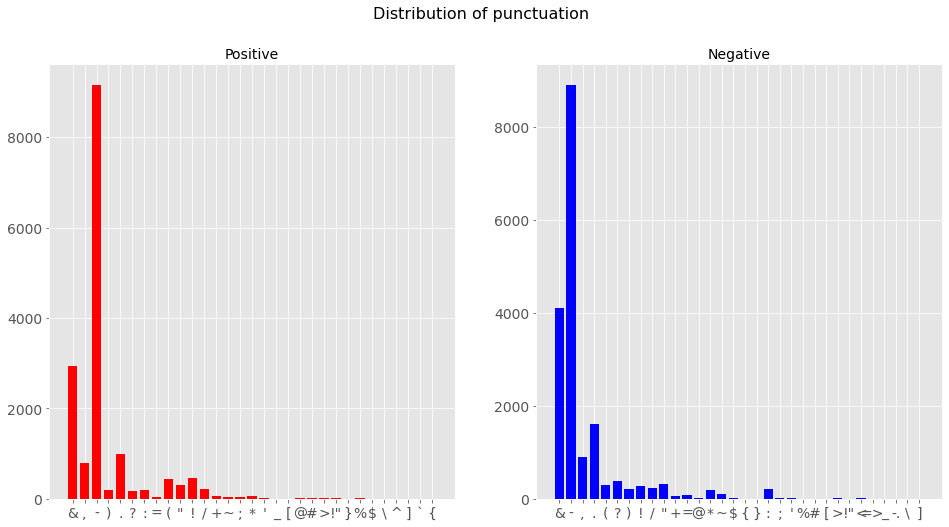

In [ ]:
x_pos, y_pos = zip(*dict_pos.items())
x_neg, y_neg = zip(*dict_neg.items())

fig,(ax1,ax2)=plt.subplots(1,2, figsize=(16,8))
ax1.bar(x_pos, y_pos, color='red')
ax1.set_title('Positive')
ax2.bar(x_neg, y_neg, color='blue')
ax2.set_title('Negative')
fig.suptitle('Distribution of punctuation')
plt.show()


In [ ]:
pos_dic_stop = defaultdict(int)
for word in corpus_pos:
    if word in stop_words:
        pos_dic_stop[word] += 1
        
top = sorted(pos_dic_stop.items(), key=lambda x:x[1], reverse=True)[:10] 

<BarContainer object of 10 artists>

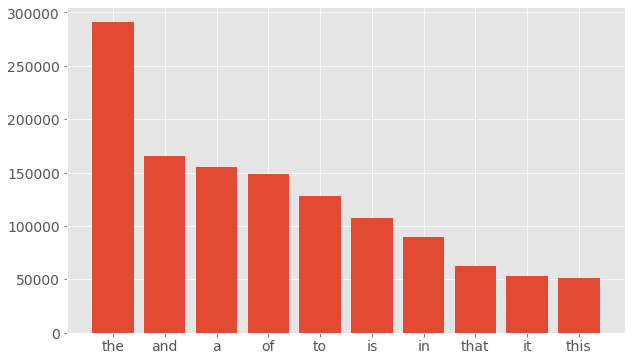

In [ ]:
x, y = zip(*top)
plt.bar(x,y)

In [ ]:
neg_dic_stop = defaultdict(int)
for word in corpus_neg:
    if word in stop_words:
        neg_dic_stop[word] += 1
        
top = sorted(neg_dic_stop.items(), key=lambda x:x[1], reverse=True)[:10] 

<BarContainer object of 10 artists>

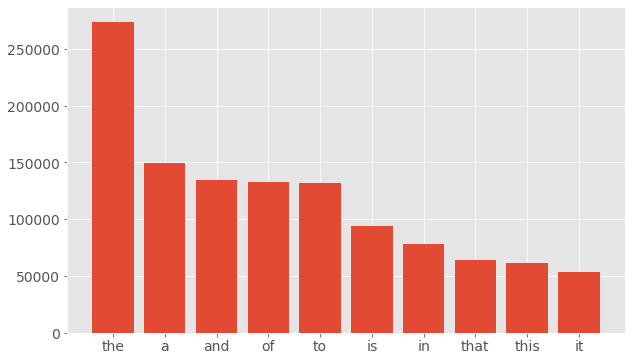

In [ ]:
x, y = zip(*top)
plt.bar(x,y)

**The distributions of punctuation and stop words do not have a significant difference for classes.**

## Words importance:

In [ ]:
def common_words(corpus):
    counter = Counter(corpus)
    most = counter.most_common()
    x = []
    y = []
    for word, count in most[:50]:
        if (word not in stop_words):
            x.append(word)
            y.append(count)    
    return x, y


### Positive:

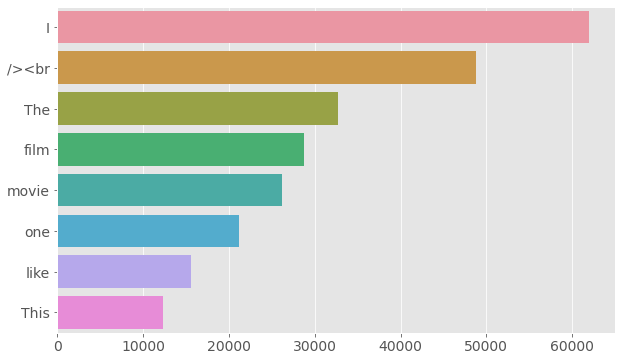

In [ ]:
x, y = common_words(corpus_pos)
sns.barplot(x=y, y=x)
plt.show()

### Negative:

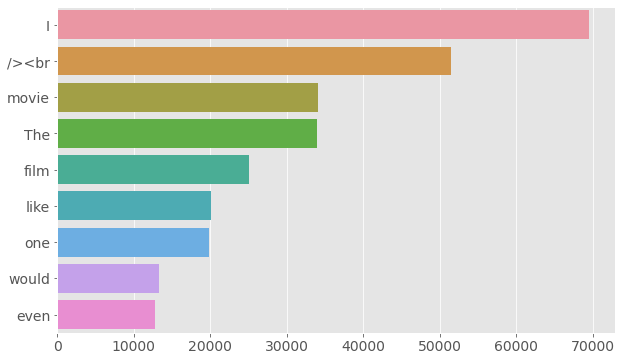

In [ ]:
x, y = common_words(corpus_neg)
sns.barplot(x=y, y=x)
plt.show()

**I was right about 'br'. It looks like it useless to make n_gramm analysis at the moment. Text needs to be cleaned.**

## Text Cleaning:

In [ ]:
def remove_email(text):
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    return email.sub(r'',text)

def remove_brackets(text):
    brackets = re.compile(r'\[[^]]*\]')
    return brackets.sub(r'', text)

def remove_URL(text):
    url = re.compile(r'http(s*)?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','', string.punctuation)
    return text.translate(table)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
     # Contractions
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"we're", "we are", phrase)
    phrase = re.sub(r"that's", "that is", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"what's", "what is", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"you're", "you are", phrase)
    phrase = re.sub(r"i'm", "i am", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"here's", "here is", phrase)
    phrase = re.sub(r"you've", "you have", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"we've", "we have", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"would've", "would have", phrase)
    phrase = re.sub(r"it'll", "it will", phrase)
    phrase = re.sub(r"we'll", "we will", phrase)
    phrase = re.sub(r"he'll", "he will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"they'll", "they will", phrase)
    phrase = re.sub(r"they'd", "they would", phrase)
    phrase = re.sub(r"they've", "they have", phrase)
    phrase = re.sub(r"i'd", "i would", phrase)
    phrase = re.sub(r"should've", "should have", phrase)
    phrase = re.sub(r"where's", "where is", phrase)
    phrase = re.sub(r"we'd", "we would", phrase)
    phrase = re.sub(r"i'll", "i will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"let's", "let us", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    phrase = re.sub(r"i'd", "i would", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"you'll", "you will", phrase)
    phrase = re.sub(r"i'll", "i will", phrase)
    phrase = re.sub(r"i'd", "i would", phrase)
    # Typos, slang and informal abbreviations
    phrase = re.sub(r"w/e", "whatever", phrase)
    phrase = re.sub(r"w/", "with", phrase)
    phrase = re.sub(r"Ph0tos", "Photos", phrase)
    phrase = re.sub(r"amirite", "am I right", phrase)
    phrase = re.sub(r"<3", "love", phrase)
    phrase = re.sub(r"trfc", "traffic", phrase)
    phrase = re.sub(r"lmao", "laughing my ass off", phrase)   
    return phrase

def cleaning(text):
    text = remove_email(text)
    text = remove_brackets(text)
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = decontracted(text)
    text = remove_punct(text)
    return text
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
%%time
data['cleaned_text']=data['text']
data['cleaned_text']=data['cleaned_text'].apply(lambda x : cleaning(x))

CPU times: user 13.4 s, sys: 8.21 ms, total: 13.4 s
Wall time: 13.4 s


In [ ]:
%%time
data['cleaned_text'] =  data['cleaned_text'].apply(lambda x: x.lower())
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', x))  
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: x.strip())

CPU times: user 1.43 s, sys: 22.8 ms, total: 1.46 s
Wall time: 1.46 s


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: word_tokenize(x))
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [i for i in x if i not in stop_words])

In [ ]:
min_length_word = 3 #All words that have length < 3 will be deleted
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [i for i in x if len(i) >= min_length_word])

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
%%time
def lem_or_stem(data_text, lemmatization=False, stemming=False):
    if lemmatization:
        data_text = data_text.apply(lambda x:[WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word)) for word in x])
    elif stemming:
        data_text = data_text.apply(lambda x:[PorterStemmer().stem(word) for word in x])
    data_text = data_text.apply(lambda x: ' '.join(x))
    return data_text

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
%%time
#Lemmatization:
data['text_after_lem'] = lem_or_stem(data['cleaned_text'], lemmatization=True)


CPU times: user 11min 13s, sys: 31.8 s, total: 11min 45s
Wall time: 11min 45s


In [ ]:
%%time
#Stemming:
data['text_after_stem'] = lem_or_stem(data['cleaned_text'], stemming=True)

CPU times: user 1min 56s, sys: 113 ms, total: 1min 56s
Wall time: 1min 56s


In [ ]:
# Before cleaning:
data.text[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# After cleaning:
data['text_after_lem'][0]

'one reviewer mention watch episode hooked right exactly happen methe first thing struck brutality unflinching scene violence set right word trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit call nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watch developed taste get accustom high level graphic violence violence injustice crooked guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch may become comfo

In [ ]:
data['text_after_stem'][0]

'one review mention watch episod hook right exactli happen meth first thing struck brutal unflinch scene violenc set right word trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show would dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch may becom comfort uncomfort viewingthat get touch darker side'

## What was removed(if was found):

 -Emails;
 
 -Brackets;
 
 -URL;

 -HTML tags;

 -Emoji;

 -Punctuation;

 -Whitespaces.

Contracted forms of words were replaced by its full form.
Lemmatization was used to get the first form of words where possible.
    

## Word importance:

In [ ]:
corpus_pos=[]
for x in data[data.target==1].text_after_lem.str.split():
    for i in x:
        corpus_pos.append(i)
corpus_neg=[]
for x in data[data.target==0].text_after_lem.str.split():
    for i in x:
        corpus_neg.append(i)

In [ ]:
pos_text = pd.Series(corpus_pos).str.cat(sep=' ')
neg_text = pd.Series(corpus_neg).str.cat(sep=' ')


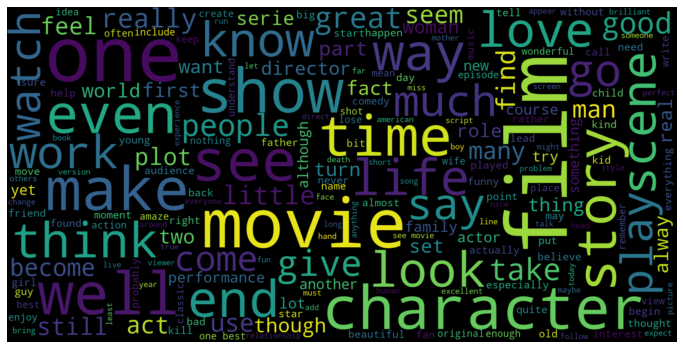

In [ ]:
# Positive
wordcloud = WordCloud(width=1600, max_words = 200, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


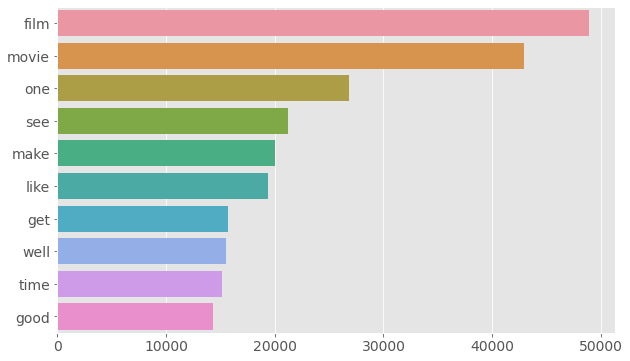

In [ ]:
x, y = common_words(corpus_pos)
sns.barplot(x=y[:10], y=x[:10])
plt.show()

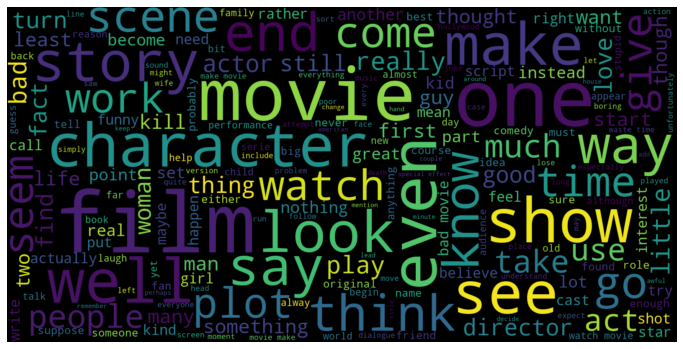

In [ ]:
# Negative
wordcloud = WordCloud(width=1600, max_words = 200, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

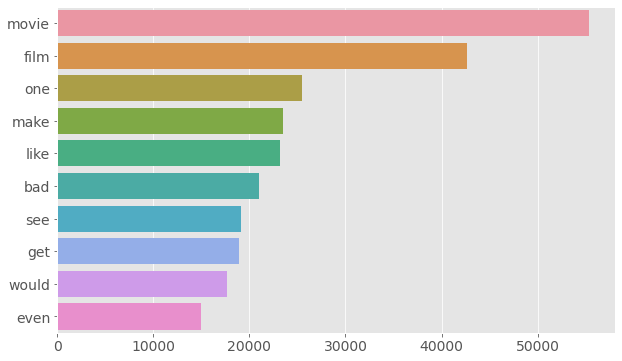

In [ ]:
x, y = common_words(corpus_neg)
sns.barplot(x=y[:10], y=x[:10])
plt.show()

## N-gramm analysis:

In [ ]:
def get_top_ngrams(corpus, n, g):
    vectorizer = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Bigram Analysis:

#### Positive:

In [ ]:
most_common_bigrams = get_top_ngrams(data[data.target==1].text_after_lem, 20, 2)
most_common_bigrams = dict(most_common_bigrams)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bigrams.keys())
temp["Count"] = list(most_common_bigrams.values())

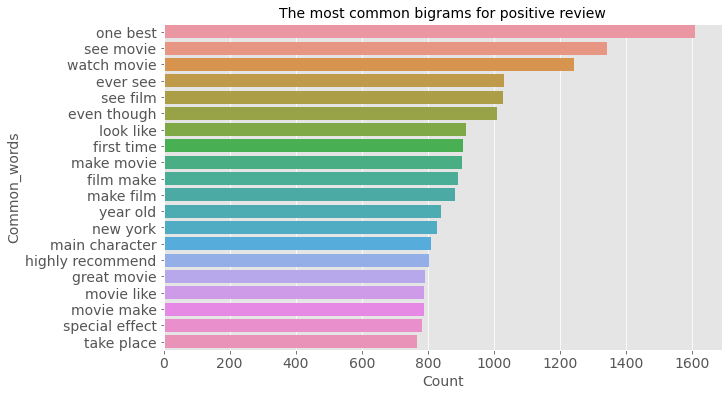

In [ ]:
sns.barplot(x="Count", y="Common_words", data=temp, orient='h')
plt.title('The most common bigrams for positive review')
plt.show()

#### Negative:

In [ ]:
most_common_bigrams = get_top_ngrams(data[data.target==0].text_after_lem, 20, 2)
most_common_bigrams = dict(most_common_bigrams)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bigrams.keys())
temp["Count"] = list(most_common_bigrams.values())

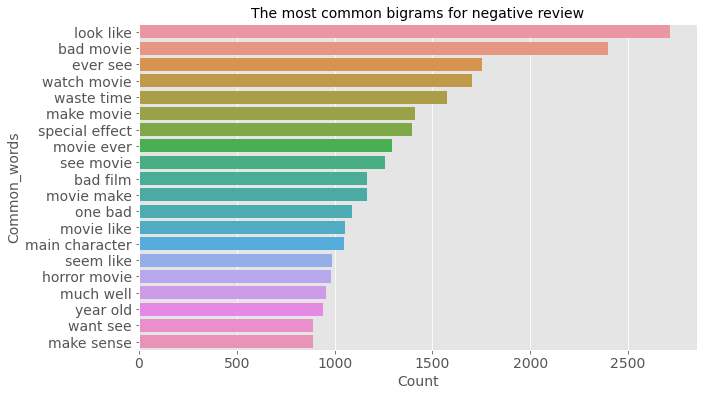

In [ ]:
sns.barplot(x="Count", y="Common_words", data=temp, orient='h')
plt.title('The most common bigrams for negative review')
plt.show()

### Trigram Analysis:

#### Positive:

In [ ]:
most_common_trigrams = get_top_ngrams(data[data.target==1].text_after_lem, 20, 3)
most_common_trigrams = dict(most_common_trigrams)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_trigrams.keys())
temp["Count"] = list(most_common_trigrams.values())

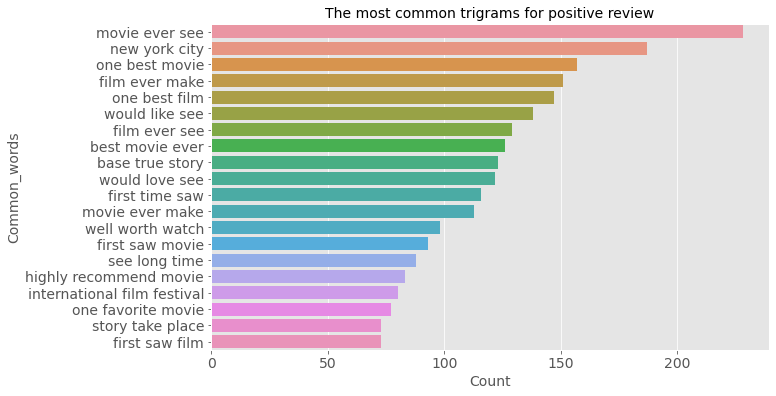

In [ ]:
sns.barplot(x="Count", y="Common_words", data=temp, orient='h')
plt.title('The most common trigrams for positive review')
plt.show()

#### Negative:

In [ ]:
most_common_trigrams = get_top_ngrams(data[data.target==0].text_after_lem, 20, 3)
most_common_trigrams = dict(most_common_trigrams)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_trigrams.keys())
temp["Count"] = list(most_common_trigrams.values())

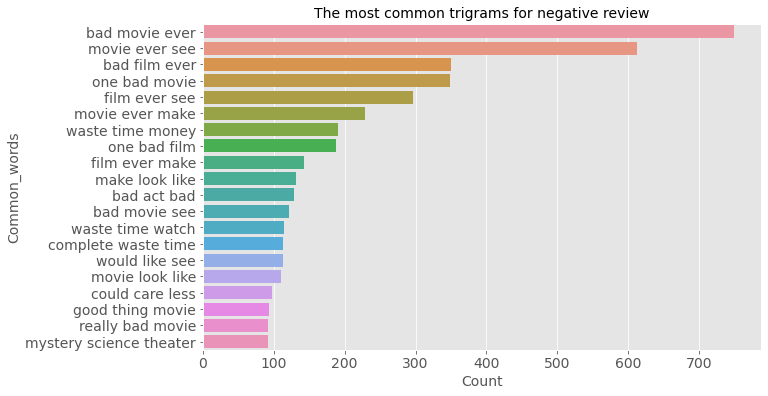

In [ ]:
sns.barplot(x="Count", y="Common_words", data=temp, orient='h')
plt.title('The most common trigrams for negative review')
plt.show()

**Positive and negative reviews have a lot in common:**
- Statistics are really simmilar;

- Unigrams are also similar;

- Bigrams and trigrams are more diffrent for two classes, but not a lot of them look useful. Moreover, the frequency of their appearing in the reviews is low.

- In wordcloud images I can see words "good" and "bad". They look useful for classification. Maybe there are more useful adjectives, which will help.

# Split the data:

In [ ]:
y = data['target'].copy()
X_lem = data['text_after_lem'].copy() 
X_stem = data['text_after_stem'].copy() 

In [ ]:
X_train_lem, X_valid_lem, y_train_lem, y_valid_lem = train_test_split(X_lem, y, test_size=0.2, shuffle=True, stratify=y)
X_train_stem, X_valid_stem, y_train_stem, y_valid_stem = train_test_split(X_stem, y, test_size=0.2, shuffle=True, stratify=y)

## TF-IDF:

In [ ]:
%%time
vectorizer = TfidfVectorizer(analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 2), lowercase=True, 
                             min_df=10,                     
                             sublinear_tf=True, 
                             max_features=10000)


X_train_lem_tfidf = vectorizer.fit_transform(X_train_lem.tolist())
X_valid_lem_tfidf = vectorizer.transform(X_valid_lem.tolist())

X_train_stem_tfidf = vectorizer.fit_transform(X_train_stem.tolist())
X_valid_stem_tfidf = vectorizer.transform(X_valid_stem.tolist())

CPU times: user 39.4 s, sys: 150 ms, total: 39.5 s
Wall time: 39.5 s


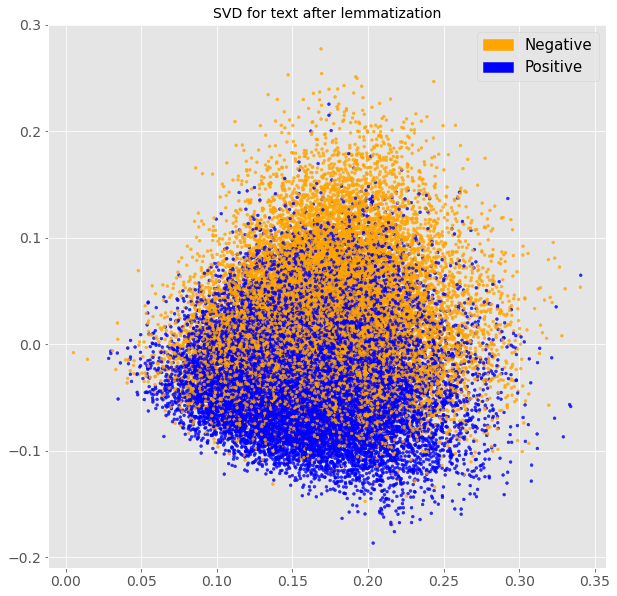

In [ ]:
fig = plt.figure(figsize=(10, 10))          
plot_SVD(X_train_lem_tfidf, y_train_lem)
plt.title('SVD for text after lemmatization')
plt.show()

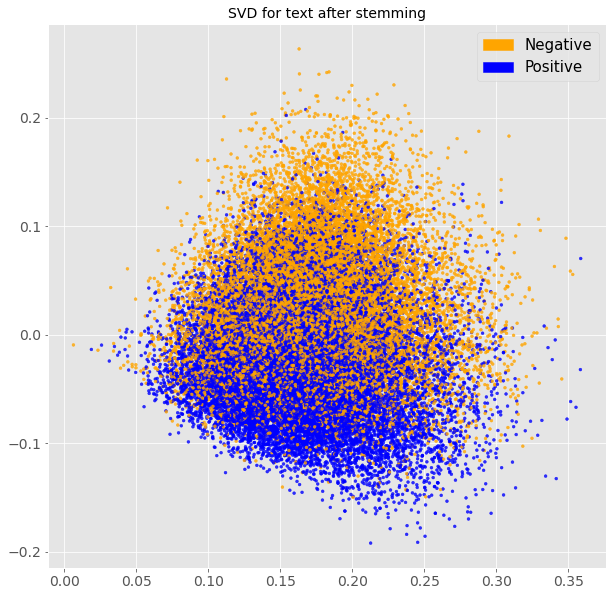

In [ ]:
fig = plt.figure(figsize=(10, 10))          
plot_SVD(X_train_stem_tfidf, y_train_stem)
plt.title('SVD for text after stemming')
plt.show()

**In TF-IDF classes after lemmatization look more distinguish.**

**It seems that using TF-IDF gives "better" results. The classes in the "cloud" look more distinguish. Hovewer, we must not forget that when the dimension is reduced, a lot of information is lost and the real picture may be completely different. Therefore, I will compare the results of both methods.**

# Classification:

**According to the task I should use SGDClassifier, Naive Bayes and SVM classifiers**.

**In addition I am going to use logistic regression and random forest classifiers as well.**

## Baseline classification:

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(n_jobs=-1, random_state=7),
    "SGDClassifier": SGDClassifier(loss="log", n_jobs=-1, random_state=7),
    "Naive Bayes": MultinomialNB()
}

#### After lemmatization:

In [ ]:

#Calculate the cross-validation score for each classifier where word were lemmatized
print('Cross-Validation Scores:')
for key, classifier in classifiers.items():
    print(key + ':')
    classifier.fit(X_train_lem_tfidf, y_train_lem)
    cv_score = cross_val_score(classifier, X_train_lem_tfidf, y_train_lem, cv=5, scoring='roc_auc')
    y_pred = classifier.predict(X_valid_lem_tfidf)
    y_proba = classifier.predict_proba(X_valid_lem_tfidf)[:, 1]
    print('roc_auc_score =', roc_auc_score(y_valid_lem, y_proba))
    print(f'cv_score = {round(cv_score.mean()*100.0, 3)}')
    print('classification_report:')
    print(classification_report(y_valid_lem, y_pred))
    print()
    print('/--'*20)


Cross-Validation Scores:
Logistic Regression:
roc_auc_score = 0.9543263790765457
cv_score = 95.478
classification_report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4940
           1       0.87      0.90      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--
SGDClassifier:
roc_auc_score = 0.9491860127436409
cv_score = 94.994
classification_report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4940
           1       0.86      0.90      0.88      4977

    accuracy                           0.87      9917
   macro avg       0.88      0.87      0.87      9917
weighted avg       0.88      0.87      0.87      9917


/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--
Naive Bay

#### After stemming:

In [ ]:

#Calculate the cross-validation score for each classifier where word were stemmed
print('Cross-Validation Scores:')
for key, classifier in classifiers.items():
    print(key + ':')
    classifier.fit(X_train_stem_tfidf, y_train_stem)
    cv_score = cross_val_score(classifier, X_train_stem_tfidf, y_train_stem, cv=5, scoring='roc_auc')
    y_pred = classifier.predict(X_valid_stem_tfidf)
    y_proba = classifier.predict_proba(X_valid_stem_tfidf)[:, 1]
    print('roc_auc_score =', roc_auc_score(y_valid_stem, y_proba))
    print(f'cv_score = {round(cv_score.mean()*100.0, 3)}')
    print('classification_report:')
    print(classification_report(y_valid_stem, y_pred))
    print()
    print('/--'*20)


Cross-Validation Scores:
Logistic Regression:
roc_auc_score = 0.9563399735951368
cv_score = 95.563
classification_report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917


/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--
SGDClassifier:
roc_auc_score = 0.9514509659413058
cv_score = 95.117
classification_report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4940
           1       0.87      0.90      0.89      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--
Naive Bay

# Hyperparameters tuning:

## Grid Search:

### For the text after lemmatization

In [ ]:
params = {
    "Logistic Regression": {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    "SGDClassifier": { "loss": ['hinge', 'log'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    "Naive Bayes": {'alpha': [0, 0.5, 1.0, 5, 10], 'fit_prior':[True, False]}
}

In [ ]:
#Using Grid search for finding the most optimal hyperparameters
def gridsearch(classifier, params, X_train, y_train):
    grid_classifier = GridSearchCV(classifier, params, scoring='roc_auc', n_jobs=-1, cv=3)
    grid_classifier.fit(X_train, y_train)
    best_classifier = grid_classifier.best_estimator_
    return best_classifier

In [ ]:
#Classifiers
log_reg = gridsearch(LogisticRegression(max_iter=1000, n_jobs=-1, random_state=7), params['Logistic Regression'], X_train_lem_tfidf, y_train_lem)
sgd = gridsearch(SGDClassifier(loss="log", n_jobs=-1, random_state=7), params['SGDClassifier'], X_train_lem_tfidf, y_train_lem)
naive = gridsearch(MultinomialNB(), params['Naive Bayes'], X_train_lem_tfidf, y_train_lem)

labels = ['negative', 'positive']

log_pred = log_reg.predict(X_valid_lem_tfidf)
sgd_pred = sgd.predict(X_valid_lem_tfidf)
naive_pred = naive.predict(X_valid_lem_tfidf)



In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplt

Logistic Regression:


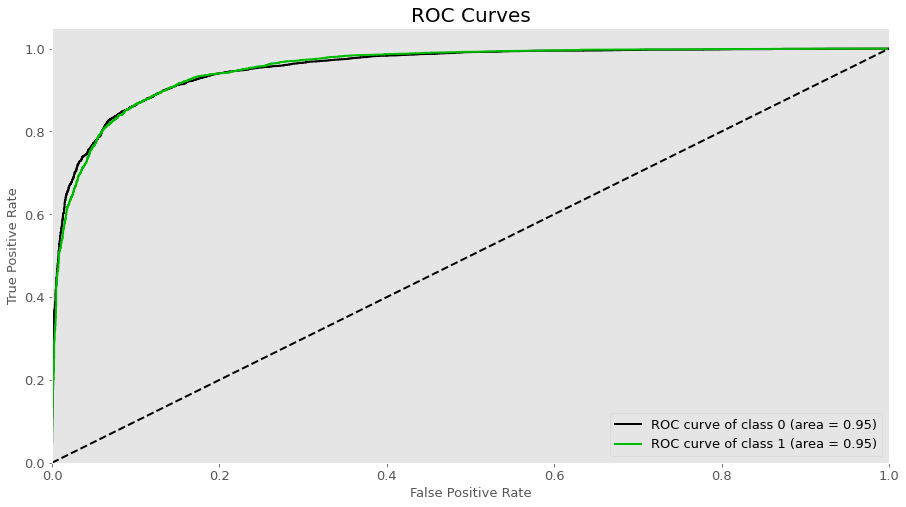

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4940
    positive       0.87      0.90      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



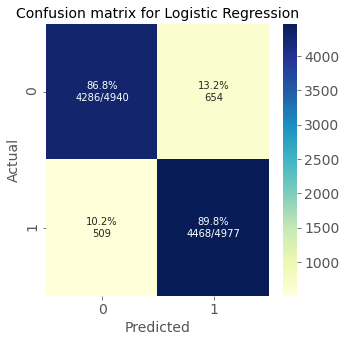

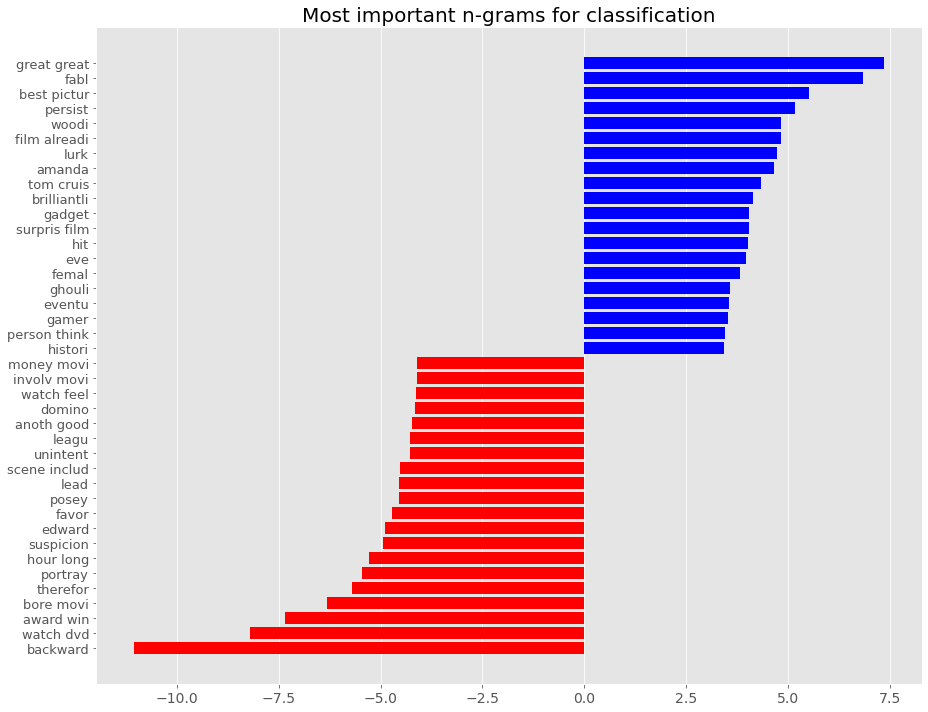

SGDClassifier:
This method doesn't have predict_proba
              precision    recall  f1-score   support

    negative       0.91      0.78      0.84      4940
    positive       0.81      0.92      0.86      4977

    accuracy                           0.85      9917
   macro avg       0.86      0.85      0.85      9917
weighted avg       0.86      0.85      0.85      9917



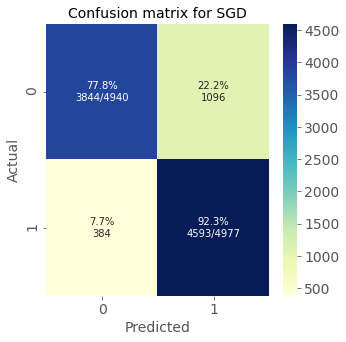

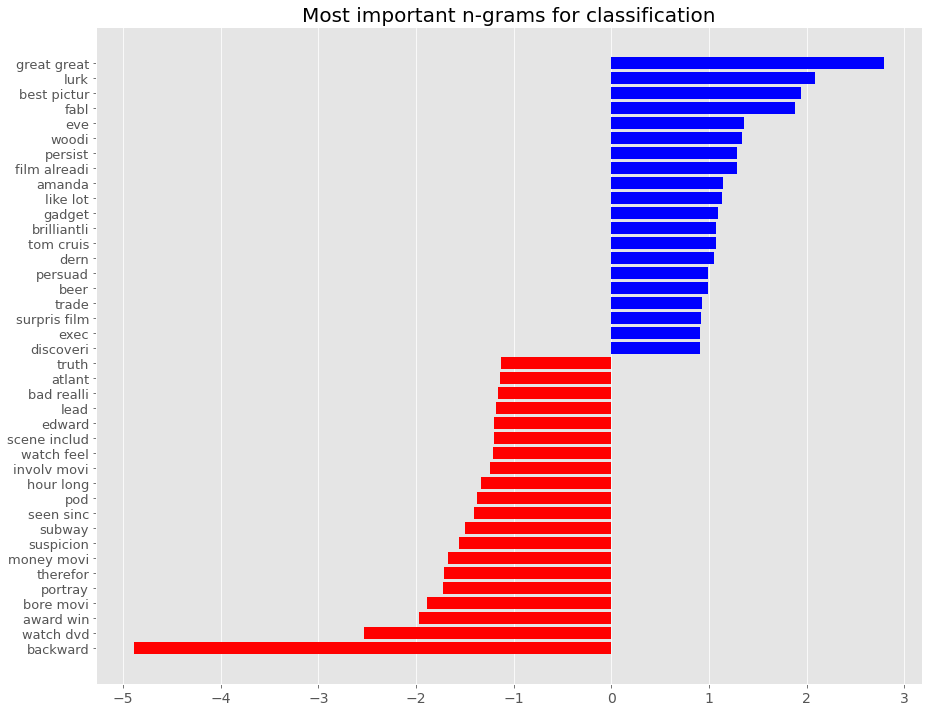

Naive Bayes:


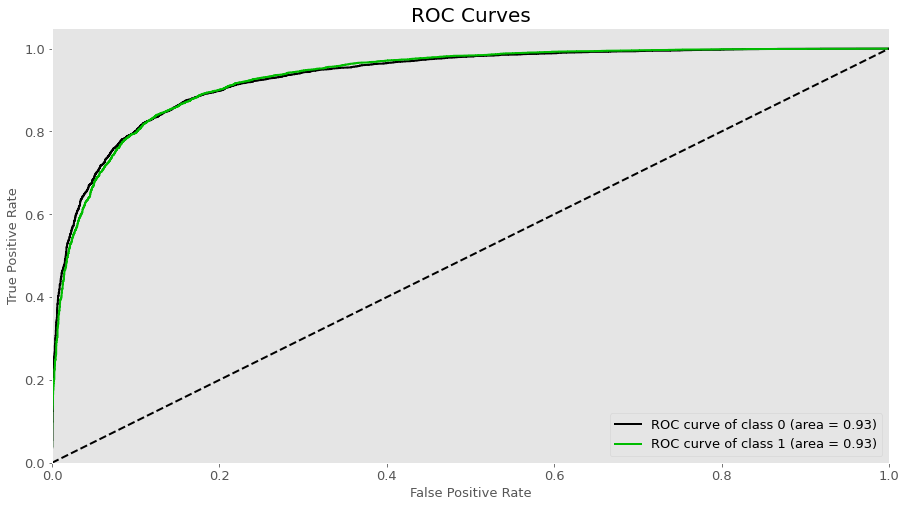

              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      4940
    positive       0.85      0.87      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



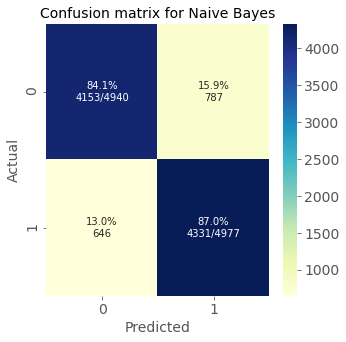

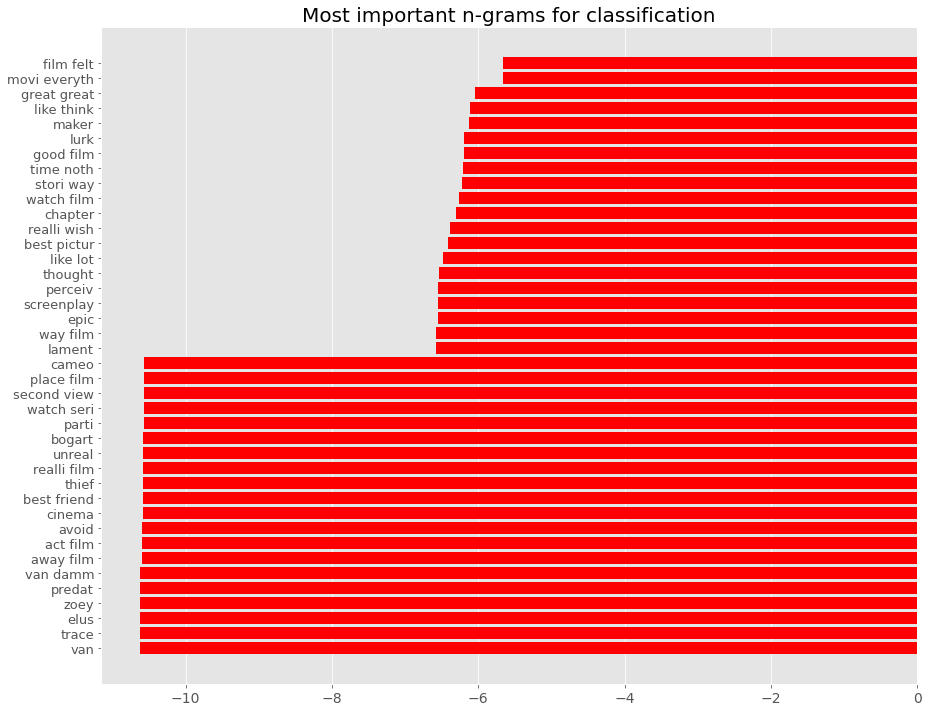

In [ ]:
print('Logistic Regression:')
log_proba = log_reg.predict_proba(X_valid_lem_tfidf)
skplt.metrics.plot_roc(y_valid_lem.values, log_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()
print(classification_report(y_valid_lem, log_pred, target_names=labels))
plot_confusion_matrix(y_valid_lem, log_pred, 'Confusion matrix for Logistic Regression')
plot_coeffs(log_reg.coef_, vectorizer.get_feature_names())

print('SGDClassifier:')
try:
  sgd_proba = sgd.predict_proba(X_valid_lem_tfidf)
  skplt.metrics.plot_roc(y_valid_lem.values, sgd_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
  plt.grid()
  plt.show()
except:
  print("This method doesn't have predict_proba")
print(classification_report(y_valid_lem, sgd_pred, target_names=labels))
plot_confusion_matrix(y_valid_lem, sgd_pred, 'Confusion matrix for SGD')
plot_coeffs(sgd.coef_, vectorizer.get_feature_names())

print('Naive Bayes:')
try:
  naive_proba = naive.predict_proba(X_valid_lem_tfidf)
  skplt.metrics.plot_roc(y_valid_lem.values, naive_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
  plt.grid()
  plt.show()
except:
  print("This method doesn't have predict_proba")
print(classification_report(y_valid_lem, naive_pred, target_names=labels))
plot_confusion_matrix(y_valid_lem, naive_pred, 'Confusion matrix for Naive Bayes')
plot_coeffs(naive.coef_, vectorizer.get_feature_names())

### For the text after stemming:

Logistic Regression:


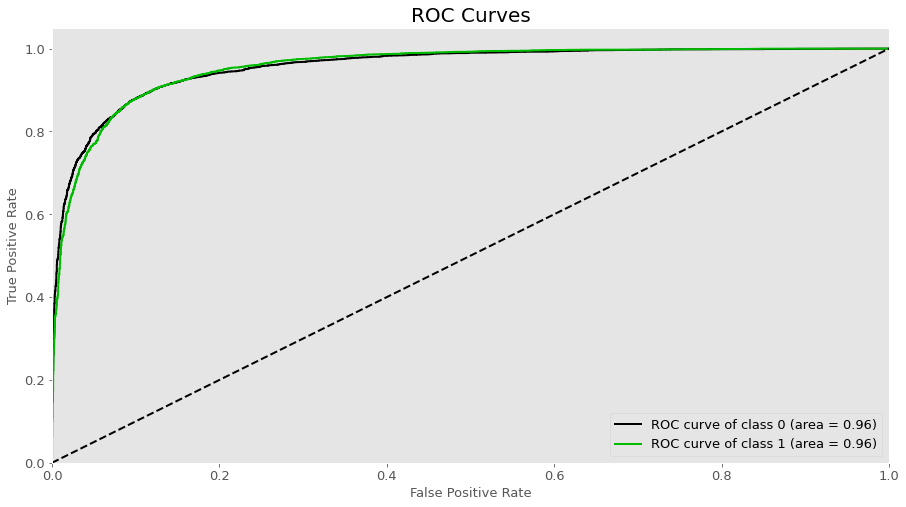

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4940
    positive       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



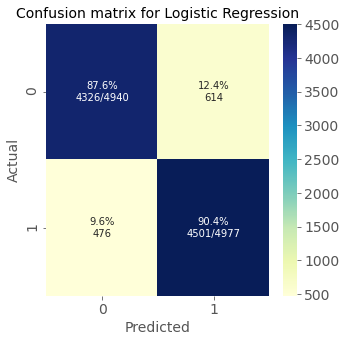

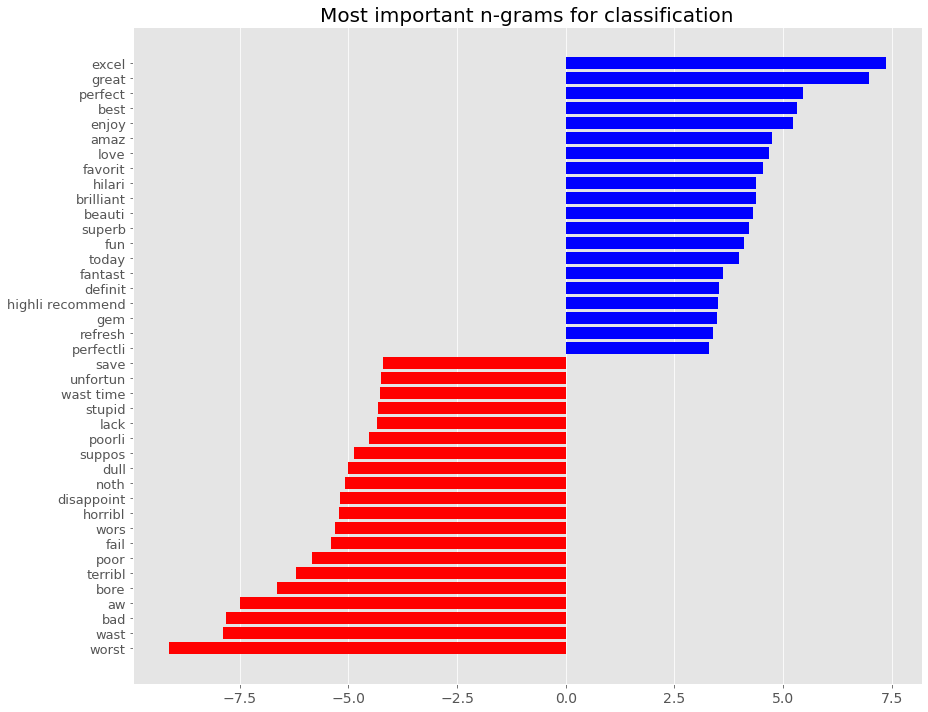

SGDClassifier:
This method doesn't have predict_proba
              precision    recall  f1-score   support

    negative       0.90      0.82      0.86      4940
    positive       0.83      0.91      0.87      4977

    accuracy                           0.86      9917
   macro avg       0.87      0.86      0.86      9917
weighted avg       0.87      0.86      0.86      9917



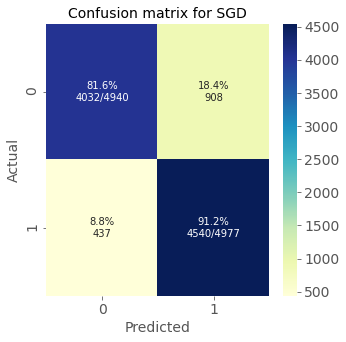

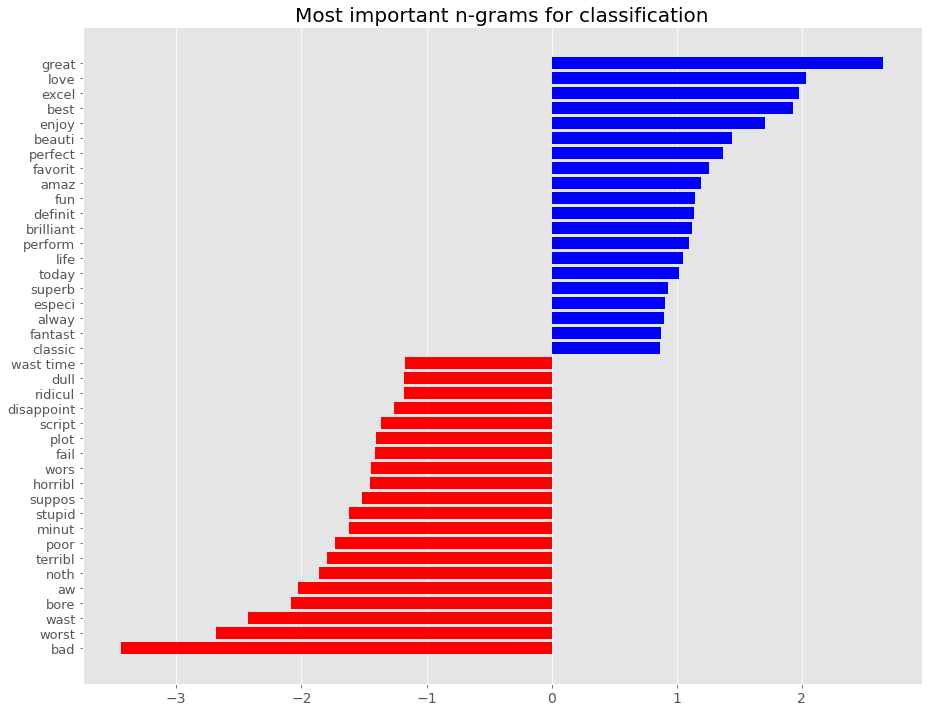

Naive Bayes:


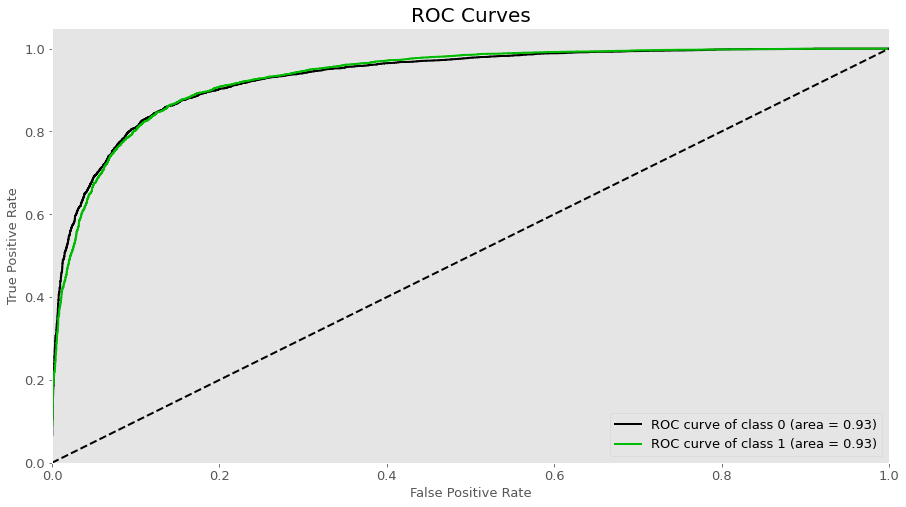

              precision    recall  f1-score   support

    negative       0.87      0.84      0.86      4940
    positive       0.85      0.88      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



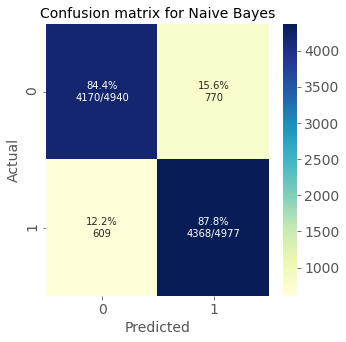

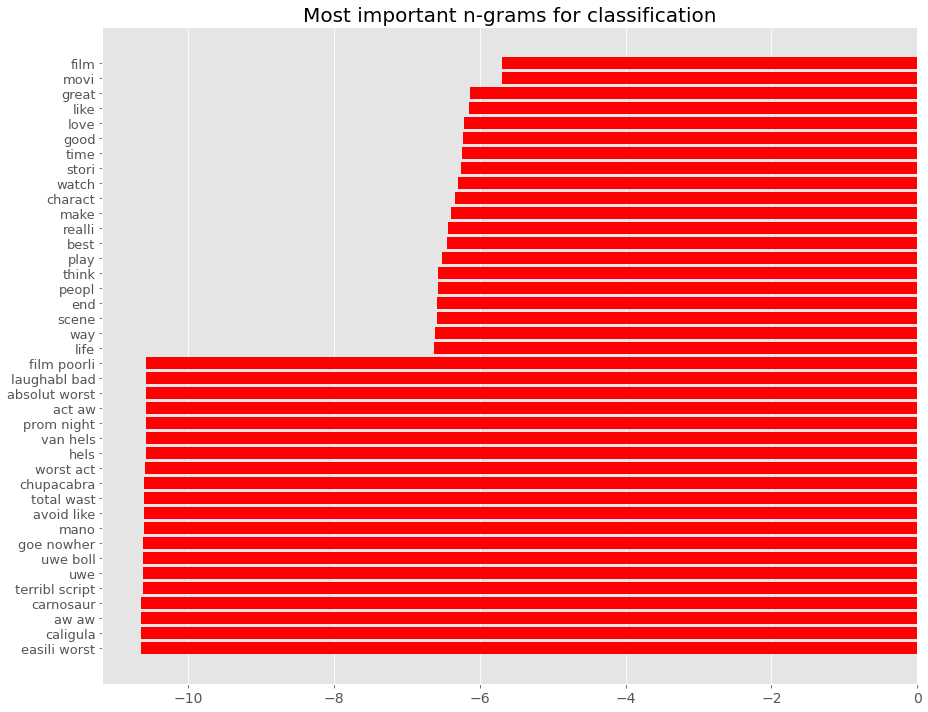

In [ ]:
#Classifiers
log_reg = gridsearch(LogisticRegression(max_iter=1000, n_jobs=-1, random_state=7), params['Logistic Regression'], X_train_stem_tfidf, y_train_stem)
sgd = gridsearch(SGDClassifier(loss="log", n_jobs=-1, random_state=7), params['SGDClassifier'], X_train_stem_tfidf, y_train_stem)
naive = gridsearch(MultinomialNB(), params['Naive Bayes'], X_train_stem_tfidf, y_train_stem)

labels = ['negative', 'positive']

log_pred = log_reg.predict(X_valid_stem_tfidf)
sgd_pred = sgd.predict(X_valid_stem_tfidf)
naive_pred = naive.predict(X_valid_stem_tfidf)

print('Logistic Regression:')
log_proba = log_reg.predict_proba(X_valid_stem_tfidf)
skplt.metrics.plot_roc(y_valid_stem.values, log_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()
print(classification_report(y_valid_stem, log_pred, target_names=labels))
plot_confusion_matrix(y_valid_stem, log_pred, 'Confusion matrix for Logistic Regression')
plot_coeffs(log_reg.coef_, vectorizer.get_feature_names())

print('SGDClassifier:')
try:
  sgd_proba = sgd.predict_proba(X_valid_stem_tfidf)
  skplt.metrics.plot_roc(y_valid_stem.values, sgd_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
  plt.grid()
  plt.show()
except:
  print("This method doesn't have predict_proba")
print(classification_report(y_valid_stem, sgd_pred, target_names=labels))
plot_confusion_matrix(y_valid_stem, sgd_pred, 'Confusion matrix for SGD')
plot_coeffs(sgd.coef_, vectorizer.get_feature_names())

print('Naive Bayes:')
try:
  naive_proba = naive.predict_proba(X_valid_stem_tfidf)
  skplt.metrics.plot_roc(y_valid_stem.values, naive_proba, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
  plt.grid()
  plt.show()
except:
  print("This method doesn't have predict_proba")
print(classification_report(y_valid_stem, naive_pred, target_names=labels))
plot_confusion_matrix(y_valid_stem, naive_pred, 'Confusion matrix for Naive Bayes')
plot_coeffs(naive.coef_, vectorizer.get_feature_names())

# Comparison of the performance of the models:

**I am going to compare metric ROC AUC, because this metric is mentioned in the task as the main metric.**

## Conclusions for comparison of the models:

- Results of logistic regression and SGD are similar as well as the set of useful words for classification. However, they are not 100% the same. Some words are different, but both sets look logical;
- Naive Bayes gives the different set of useful words and in contrast to SGD and LR, it uses not only unigrams but and bigrams. However, its  performance is worse;
- Random forest is a powerful algorithm and it gives good results. However, I think it could be better with more accurate tunning parameters;
- According to AUC ROC the best classifier here is Logistic Regression. It doesn't mean that this classifier is the best of the best, maybe with the different tuning of parameters or under different circumstances, we will get another the best algorithm;
- Using lemmatization and stemming gave similar results.

# Tensorflow: Keras

## LSTM:

### 1 layer:

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
X_train = np.asarray(X_train_lem)
X_valid = np.asarray(X_valid_lem)

In [ ]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
max_features = 1000
sequence_length = 300

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
vectorize_layer.adapt(X_train)

In [ ]:
model_lstm = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_lstm.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=50,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/50
620/620 [==============================] - 16s 25ms/step - loss: 0.6557 - auc: 0.6568 - accuracy: 0.6166 - val_loss: 0.6149 - val_auc: 0.7435 - val_accuracy: 0.7331
Epoch 2/50
620/620 [==============================] - 14s 23ms/step - loss: 0.6167 - auc: 0.7815 - accuracy: 0.7545 - val_loss: 0.6168 - val_auc: 0.7340 - val_accuracy: 0.7178
Epoch 3/50
620/620 [==============================] - 15s 24ms/step - loss: 0.6149 - auc: 0.7682 - accuracy: 0.7333 - val_loss: 0.6279 - val_auc: 0.8149 - val_accuracy: 0.6779
Epoch 4/50
620/620 [==============================] - 15s 24ms/step - loss: 0.6062 - auc: 0.8210 - accuracy: 0.7661 - val_loss: 0.5858 - val_auc: 0.8563 - val_accuracy: 0.8242
Epoch 5/50
620/620 [==============================] - 15s 24ms/step - loss: 0.5887 - auc: 0.8346 - accuracy: 0.8097 - val_loss: 0.6110 - val_auc: 0.7421 - val_accuracy: 0.7312
Epoch 6/50
620/620 [==============================] - 15s 24ms/step - loss: 0.6012 - auc: 0.7919 - accuracy: 0.7767 - va

In [ ]:
def plot_history(history):
    print('Learning curves:')
    metrics = list(history.history.keys())
    
    loss = history.history[f'{metrics[0]}']
    auc = history.history[f'{metrics[1]}']
    acc = history.history[f'{metrics[2]}']

    val_loss = history.history[f'{metrics[3]}']
    val_auc = history.history[f'{metrics[4]}']
    val_acc = history.history[f'{metrics[5]}']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.plot(x, auc, 'b', label='Training auc')
    plt.plot(x, val_auc, 'r', label='Validation auc')
    plt.xlabel('epochs')
    plt.ylabel('auc')
    plt.title('Training and validation auc')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
def evaluate_model(model, history):
    loss, auc, acc = model.evaluate(X_train, np.asarray(y_train_lem), verbose=False)
    print("Training auc: {:.4f}; Training acc: {:.4f}".format(auc, acc))
    loss, auc, acc = model.evaluate(X_valid, np.asarray(y_valid_lem), verbose=False)
    print("Validation auc: {:.4f}; Validation acc: {:.4f}".format(auc, acc))
    plot_history(history)
  


Training auc: 0.9064; Training acc: 0.8956
Validation auc: 0.8708; Validation acc: 0.8520
Learning curves:


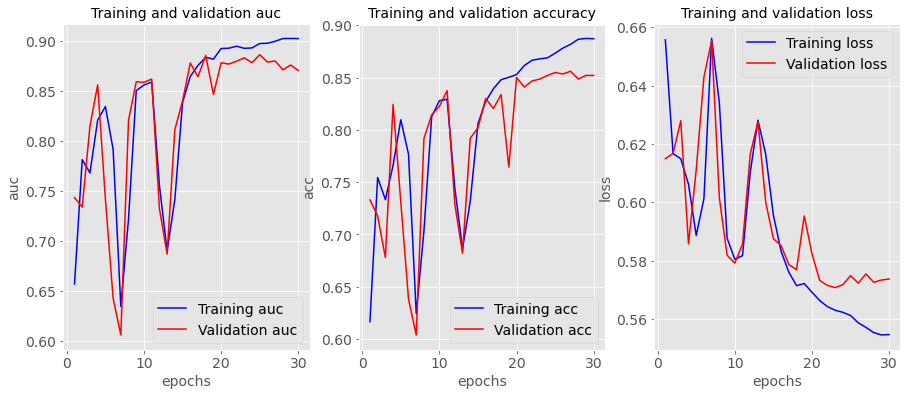

In [ ]:
evaluate_model(model_lstm, history)

### 2 layers:

In [ ]:
model_lstm_2 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64,  return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])

history = model_lstm_2.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=50,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/50
620/620 [==============================] - 26s 41ms/step - loss: 0.6938 - auc_1: 0.4983 - accuracy: 0.4981 - val_loss: 0.6932 - val_auc_1: 0.5000 - val_accuracy: 0.4981
Epoch 2/50
620/620 [==============================] - 23s 37ms/step - loss: 0.6946 - auc_1: 0.5080 - accuracy: 0.4993 - val_loss: 0.6931 - val_auc_1: 0.5040 - val_accuracy: 0.4981
Epoch 3/50
620/620 [==============================] - 23s 36ms/step - loss: 0.6931 - auc_1: 0.5023 - accuracy: 0.4981 - val_loss: 0.6931 - val_auc_1: 0.5025 - val_accuracy: 0.4981
Epoch 4/50
620/620 [==============================] - 23s 37ms/step - loss: 0.6590 - auc_1: 0.6836 - accuracy: 0.6142 - val_loss: 0.6498 - val_auc_1: 0.6618 - val_accuracy: 0.6171
Epoch 5/50
620/620 [==============================] - 23s 37ms/step - loss: 0.6283 - auc_1: 0.7794 - accuracy: 0.7325 - val_loss: 0.6117 - val_auc_1: 0.8048 - val_accuracy: 0.7412
Epoch 6/50
620/620 [==============================] - 22s 36ms/step - loss: 0.6070 - auc_1: 0.8054 -

Training auc: 0.9046; Training acc: 0.8905
Validation auc: 0.8735; Validation acc: 0.8506
Learning curves:


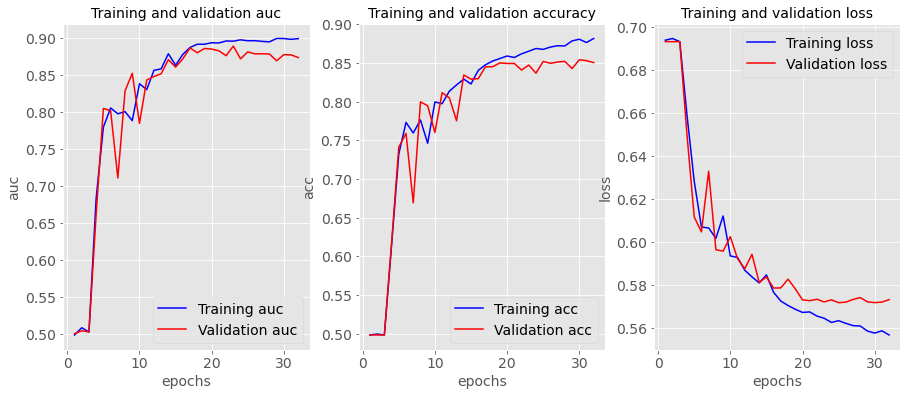

In [ ]:
evaluate_model(model_lstm_2, history)

## Bidirectional LSTM:

### 1 layer:

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])
history = model.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=50,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/50
620/620 [==============================] - 26s 41ms/step - loss: 0.6938 - auc_2: 0.4994 - accuracy: 0.4981 - val_loss: 0.6932 - val_auc_2: 0.5004 - val_accuracy: 0.4981
Epoch 2/50
620/620 [==============================] - 22s 36ms/step - loss: 0.6785 - auc_2: 0.5781 - accuracy: 0.5586 - val_loss: 0.6466 - val_auc_2: 0.7806 - val_accuracy: 0.7338
Epoch 3/50
620/620 [==============================] - 23s 37ms/step - loss: 0.6378 - auc_2: 0.7050 - accuracy: 0.6738 - val_loss: 0.6070 - val_auc_2: 0.8359 - val_accuracy: 0.7548
Epoch 4/50
620/620 [==============================] - 23s 36ms/step - loss: 0.6155 - auc_2: 0.7816 - accuracy: 0.7422 - val_loss: 0.6008 - val_auc_2: 0.8155 - val_accuracy: 0.7635
Epoch 5/50
620/620 [==============================] - 22s 36ms/step - loss: 0.5922 - auc_2: 0.8446 - accuracy: 0.7993 - val_loss: 0.5861 - val_auc_2: 0.8557 - val_accuracy: 0.8121
Epoch 6/50
620/620 [==============================] - 22s 36ms/step - loss: 0.5841 - auc_2: 0.8598 -

Training auc: 0.8627; Training acc: 0.8363
Validation auc: 0.8543; Validation acc: 0.8255
Learning curves:


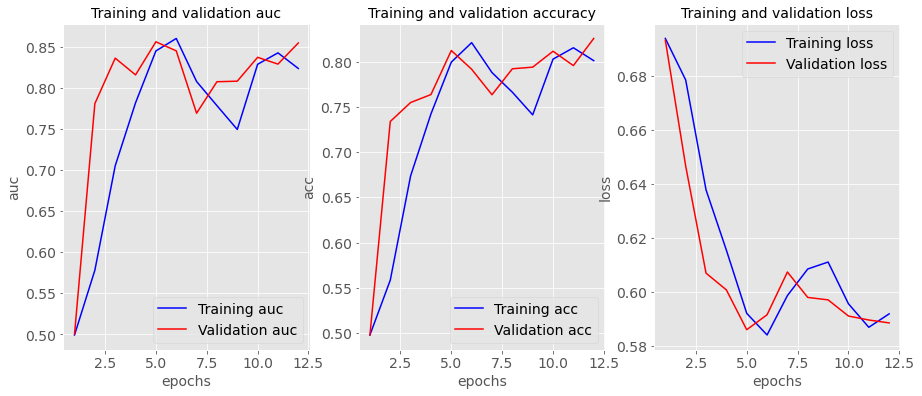

In [ ]:
evaluate_model(model, history)

### 2 layers:

In [ ]:
model_2 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])
history = model_2.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=50,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/50
620/620 [==============================] - 44s 70ms/step - loss: 0.6936 - auc_3: 0.4988 - accuracy: 0.4980 - val_loss: 0.6932 - val_auc_3: 0.5001 - val_accuracy: 0.4981
Epoch 2/50
620/620 [==============================] - 39s 63ms/step - loss: 0.6820 - auc_3: 0.5540 - accuracy: 0.5480 - val_loss: 0.6625 - val_auc_3: 0.6829 - val_accuracy: 0.6299
Epoch 3/50
620/620 [==============================] - 39s 63ms/step - loss: 0.6259 - auc_3: 0.7868 - accuracy: 0.7404 - val_loss: 0.6377 - val_auc_3: 0.8010 - val_accuracy: 0.7239
Epoch 4/50
620/620 [==============================] - 40s 64ms/step - loss: 0.6025 - auc_3: 0.8317 - accuracy: 0.7765 - val_loss: 0.5916 - val_auc_3: 0.8513 - val_accuracy: 0.7808
Epoch 5/50
620/620 [==============================] - 40s 64ms/step - loss: 0.5832 - auc_3: 0.8658 - accuracy: 0.8221 - val_loss: 0.5771 - val_auc_3: 0.8746 - val_accuracy: 0.8344
Epoch 6/50
620/620 [==============================] - 39s 63ms/step - loss: 0.5769 - auc_3: 0.8711 -

Training auc: 0.8993; Training acc: 0.8891
Validation auc: 0.8607; Validation acc: 0.8464
Learning curves:


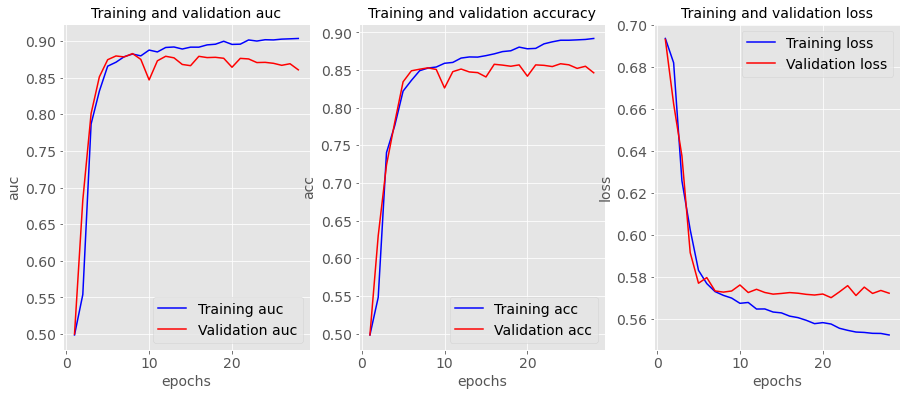

In [ ]:
evaluate_model(model_2, history)

# Pretrained embedings:

## glove.twitter.27B.100d.txt

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    cnt = 0
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(lst_corpus)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(len(X_train[0, :]))

300


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    filepath='/content/drive/My Drive/Colab Notebooks/glove.twitter.27B.100d.txt',
    word_index=tokenizer.word_index, 
    embedding_dim=embedding_dim)

0.3043515197854278

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])
history = model.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=10,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/10
620/620 [==============================] - 34s 54ms/step - loss: 0.6448 - auc_4: 0.7057 - accuracy: 0.6670 - val_loss: 0.6200 - val_auc_4: 0.8141 - val_accuracy: 0.7414
Epoch 2/10
620/620 [==============================] - 32s 52ms/step - loss: 0.6315 - auc_4: 0.7314 - accuracy: 0.6984 - val_loss: 0.5964 - val_auc_4: 0.8367 - val_accuracy: 0.7957
Epoch 3/10
620/620 [==============================] - 32s 52ms/step - loss: 0.5972 - auc_4: 0.8264 - accuracy: 0.7907 - val_loss: 0.5892 - val_auc_4: 0.8641 - val_accuracy: 0.8229
Epoch 4/10
620/620 [==============================] - 32s 52ms/step - loss: 0.5854 - auc_4: 0.8540 - accuracy: 0.8155 - val_loss: 0.5789 - val_auc_4: 0.8708 - val_accuracy: 0.8330
Epoch 5/10
620/620 [==============================] - 32s 52ms/step - loss: 0.5808 - auc_4: 0.8526 - accuracy: 0.8233 - val_loss: 0.5775 - val_auc_4: 0.8772 - val_accuracy: 0.8415
Epoch 6/10
620/620 [==============================] - 32s 52ms/step - loss: 0.5743 - auc_4: 0.8762 -

Training auc: 0.8930; Training acc: 0.8684
Validation auc: 0.8768; Validation acc: 0.8522
Learning curves:


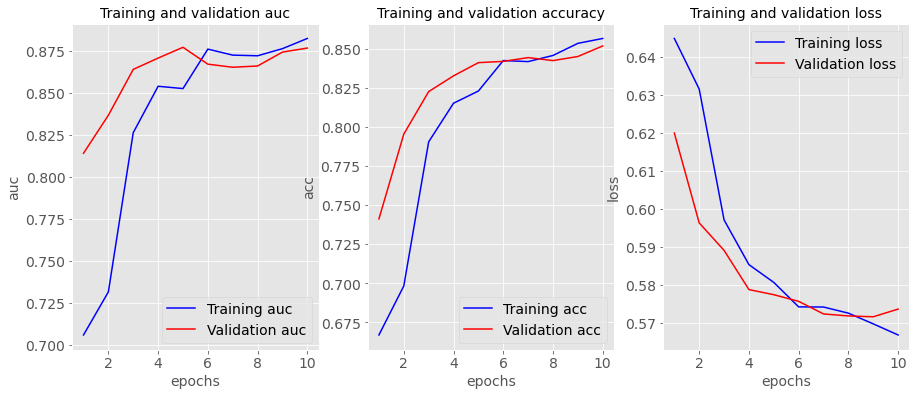

In [ ]:
evaluate_model(model, history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])
history = model.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=30,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )

Epoch 1/30
620/620 [==============================] - 148s 239ms/step - loss: 0.6251 - auc_5: 0.7666 - accuracy: 0.7156 - val_loss: 0.5995 - val_auc_5: 0.8319 - val_accuracy: 0.7635
Epoch 2/30
620/620 [==============================] - 146s 235ms/step - loss: 0.5928 - auc_5: 0.8366 - accuracy: 0.8114 - val_loss: 0.5811 - val_auc_5: 0.8470 - val_accuracy: 0.8142
Epoch 3/30
620/620 [==============================] - 145s 234ms/step - loss: 0.5707 - auc_5: 0.8783 - accuracy: 0.8511 - val_loss: 0.5711 - val_auc_5: 0.8769 - val_accuracy: 0.8574
Epoch 4/30
620/620 [==============================] - 144s 233ms/step - loss: 0.5615 - auc_5: 0.8955 - accuracy: 0.8710 - val_loss: 0.5747 - val_auc_5: 0.8881 - val_accuracy: 0.8647
Epoch 5/30
620/620 [==============================] - 143s 231ms/step - loss: 0.5670 - auc_5: 0.8761 - accuracy: 0.8595 - val_loss: 0.5724 - val_auc_5: 0.8514 - val_accuracy: 0.8386
Epoch 6/30
620/620 [==============================] - 142s 229ms/step - loss: 0.5595 - auc

Training auc: 0.9350; Training acc: 0.9293
Validation auc: 0.8831; Validation acc: 0.8728
Learning curves:


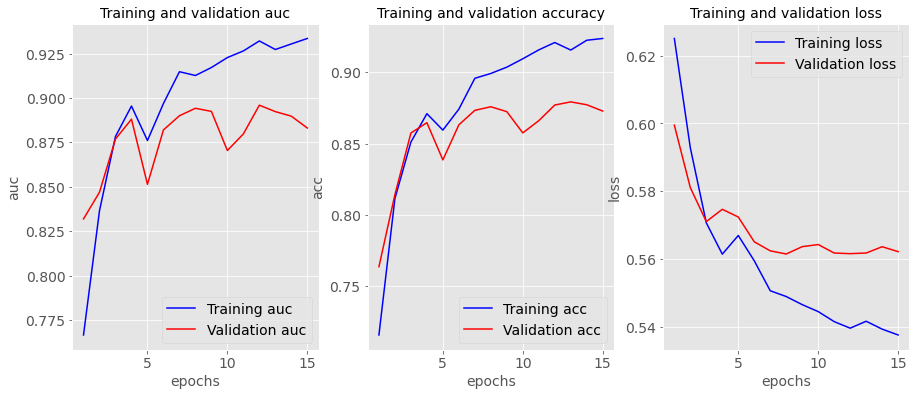

In [ ]:
evaluate_model(model, history)

## glove.6B.100d.txt

Epoch 1/20
620/620 [==============================] - 147s 237ms/step - loss: 0.6353 - auc_6: 0.7532 - accuracy: 0.6927 - val_loss: 0.5866 - val_auc_6: 0.8760 - val_accuracy: 0.8249
Epoch 2/20
620/620 [==============================] - 145s 234ms/step - loss: 0.6011 - auc_6: 0.8141 - accuracy: 0.7893 - val_loss: 0.6190 - val_auc_6: 0.8359 - val_accuracy: 0.7996
Epoch 3/20
620/620 [==============================] - 144s 233ms/step - loss: 0.5809 - auc_6: 0.8579 - accuracy: 0.8350 - val_loss: 0.5917 - val_auc_6: 0.7936 - val_accuracy: 0.7758
Epoch 4/20
620/620 [==============================] - 143s 230ms/step - loss: 0.5651 - auc_6: 0.8869 - accuracy: 0.8668 - val_loss: 0.5742 - val_auc_6: 0.8752 - val_accuracy: 0.8630
Epoch 5/20
620/620 [==============================] - 144s 233ms/step - loss: 0.5622 - auc_6: 0.8911 - accuracy: 0.8741 - val_loss: 0.5876 - val_auc_6: 0.8725 - val_accuracy: 0.8470
Epoch 6/20
620/620 [==============================] - 145s 234ms/step - loss: 0.5667 - auc

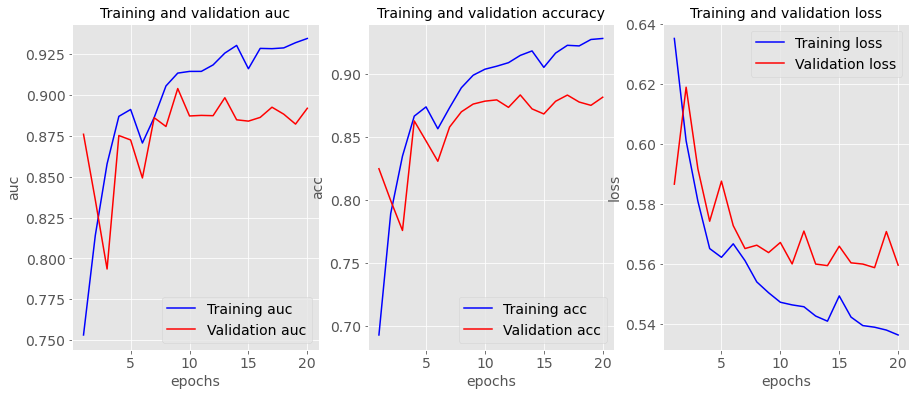

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    filepath='/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt',
    word_index=tokenizer.word_index, 
    embedding_dim=embedding_dim)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True),
    tf.keras.layers.I failed to achieve better results with neural networks(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])
history = model.fit(x=X_train,
                    y=np.asarray(y_train_lem),
                    epochs=20,
                    validation_data=(X_valid, np.asarray(y_valid_lem)),
                    batch_size=64,
                    callbacks=[early_stop, PrintDot()]
                    )
evaluate_model(model, history)

# Conclusions:

- Tensorflow(keras) was used;
- LSTM with 1 and 2 layers were used;
- Bidirectional LSTM with 1 and 2 layers were used;
- Pretrained embeddings were used: with and without training;
- I failed to achieve better results with neural networks;
- The best result(among NN) was achieved by using Bidirectional LSTM(2 layers) and pretrained embedding glove.6B.100d.txt: Validation auc: 0.8919; Validation acc: 0.8818.



---



---

